<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/20.00-Cenario_Rio_Residencias.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- O cenário de múltiplos do Pop350: parâmetros](19.00-Construindo_Cenarios_e_Pop_Multi_350_parametros.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Modelo individual: incluindo a fase de exposição ->](21.00-Modelo_individual_infeccao_e_recuperacao.ipynb)

---


# O cenário da cidade do Rio de Janeiro: rede residencial

- Começamos a construir o cenário da cidade do Rio de Janeiro

- Utilizamos os dados do [Landscan](https://landscan.ornl.gov), que fornece a distribuição populacional de cada região do planeta, em blocos de aproximadamente $1\;\texttt{km}^2$.

- Com base nessa distribuição e em uma tabela de censo residencial (porcentagem de residências por número de residentes), montamos a rede residencial.

In [2]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [3]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import episiming

In [4]:
sns.set_style("darkgrid")

In [5]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 27/Jun/2020


## Distribuição populacional da cidade do Rio de Janeiro

### Carregando os dados

Os dados populacionais por quilômetro quadrado da cidade do Rio de Janeiro foram obtidos pelo [Landscan](https://landscan.ornl.gov).

In [6]:
landscan_rio = np.load('../input/dados_rio/landscan_rio.npy').astype(int)

### Análise

In [7]:
print(f'Mínimo: {landscan_rio.min()}')
print(f'Máximo: {landscan_rio.max()}')
print(f'Média: {landscan_rio.mean():.2f}')
print(f'Total: {landscan_rio.sum():.2f}')
print(f'Menor valor positivo: {landscan_rio[landscan_rio>0].min()}')
print(f'Blocos vazios: {len(landscan_rio[landscan_rio==0])}')
print(f'Blocos negativos: {len(landscan_rio[landscan_rio<0])}')
print(f'Dimensão "x": {landscan_rio.shape[1]}')
print(f'Dimensão "y": {landscan_rio.shape[0]}')
print(f'Número de blocos: {landscan_rio.shape[0]*landscan_rio.shape[1]}')

Mínimo: -1
Máximo: 55124
Média: 2118.57
Total: 6857814.00
Menor valor positivo: 1
Blocos vazios: 1727
Blocos negativos: 39
Dimensão "x": 83
Dimensão "y": 39
Número de blocos: 3237


### Visualização

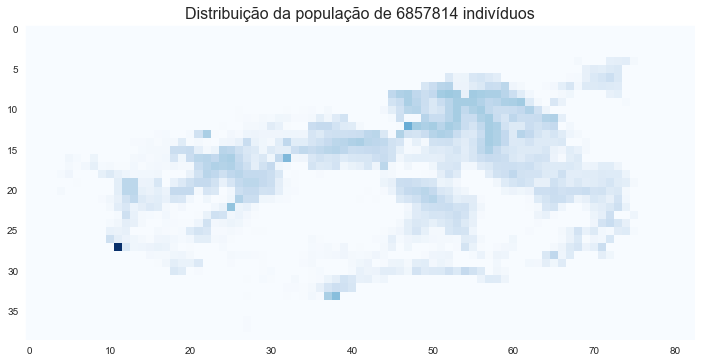

In [8]:
plt.figure(figsize=(12,6))
plt.imshow(landscan_rio, cmap='Blues', interpolation='nearest')
plt.grid(False)
plt.title(f'Distribuição da população de {int(landscan_rio.sum())} indivíduos', fontsize=16)
plt.show()

### Outra visualização

Em outro esquema de cores para destacar valores extremos e médios

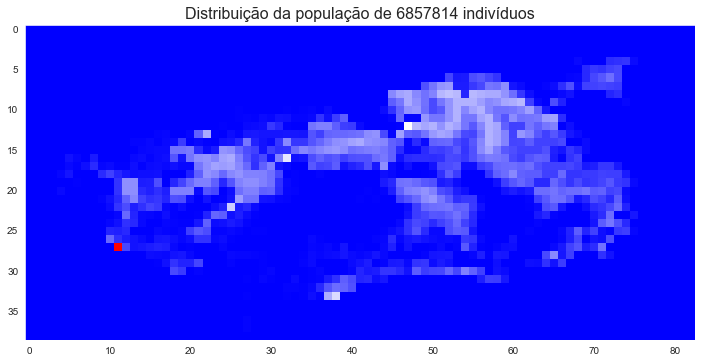

In [9]:
plt.figure(figsize=(12,6))
plt.imshow(landscan_rio, cmap='bwr', interpolation='nearest')
plt.grid(False)
plt.title(f'Distribuição da população de {int(landscan_rio.sum())} indivíduos', fontsize=16)
plt.show()

### Valor destoante

O ponto vermelho no mapa é suspeito. Ele certamente é o bloco de valor máximo 55.124. Os blocos brancos devem estar próximos da metade, em torno de 27 mil. Os blocos azulados estão abaixo deste. Vejamos os blocos que ficam acima de 20 mil:

In [10]:
print(f'Populações dos blocos com mais de 20 mil pessoas: {landscan_rio[landscan_rio>20000]}')

Populações dos blocos com mais de 20 mil pessoas: [20720 27626 24812 22101 55124 23667]


São apenas 6 blocos, sendo que apenas 2 têm mais de 25 mil, dentre eles o de 55.124, uma diferença enorme.

Uma busca nos revela a posição do bloco de máximo:

In [11]:
landscan_rio[27,11]

55124

### Zerando os valores negativos

Os pontos com valor -1 indicam falta de informação.

Para a construção da rede de residências, vamos apenas substituí-los por 0.

In [11]:
landscan_rio = np.maximum(landscan_rio, 0)

### Visualização em escala logarítmica

Visualizamos 

$$ \ln( 1 + \textrm{população})
$$

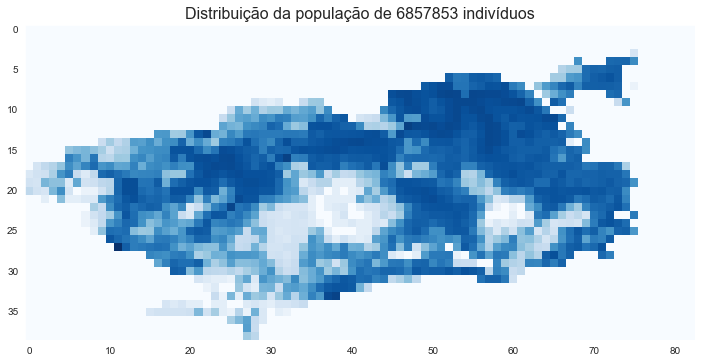

In [12]:
plt.figure(figsize=(12,6))
plt.imshow(np.log(1 + landscan_rio), cmap='Blues', interpolation='nearest')
plt.grid(False)
plt.title(f'Distribuição da população de {int(landscan_rio.sum())} indivíduos', fontsize=16)
plt.show()

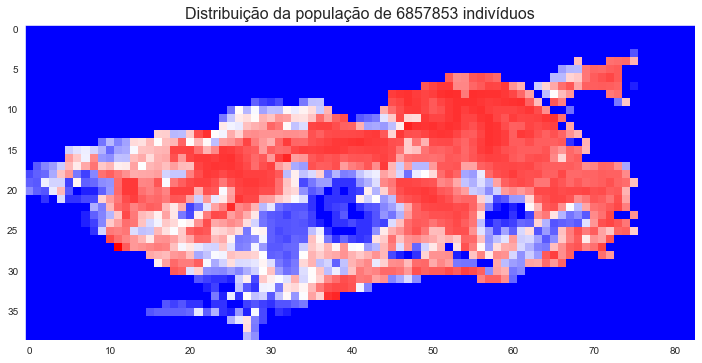

In [13]:
plt.figure(figsize=(12,6))
plt.imshow(np.log(1 + landscan_rio), cmap='bwr', interpolation='nearest')
plt.grid(False)
plt.title(f'Distribuição da população de {int(landscan_rio.sum())} indivíduos', fontsize=16)
plt.show()

In [14]:
landscan_rio_centro = landscan_rio[:, 40:]

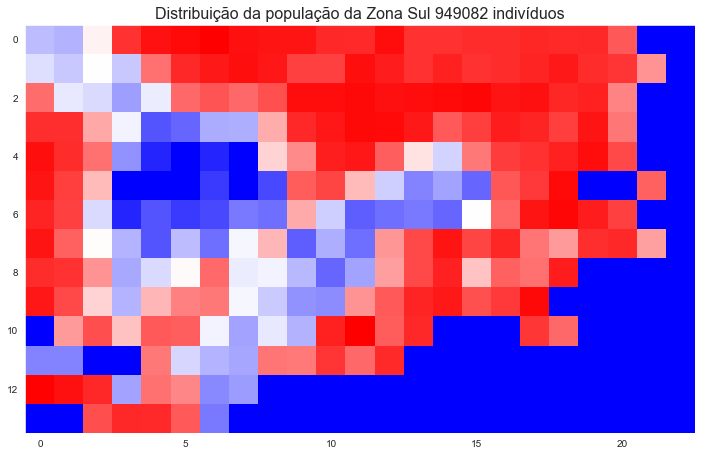

In [15]:
plt.figure(figsize=(12,12))
plt.imshow(np.log(1 + landscan_rio[18:32, 54:77]), cmap='bwr', interpolation='nearest')
plt.grid(False)
plt.title(f'Distribuição da população da Zona Sul {landscan_rio[18:32, 54:77].sum()} indivíduos', fontsize=16)
plt.show()

## Rede residencial

A distribuição da população em residências é feita segundo um censo com a porcentagem de residências por número de residentes:

In [16]:
censo_residencial = np.array([.21, .26, .20, .17, .08, .04, .02, .02])

Na montagem do cenário, com o objetivo de realizar testes mais rápidos, com populações menores, dividimos a população de cada bloco por um determinado fator.

Essa divisão nos dá números em ponto flutuante, que então truncamos para a sua parte inteira.

In [25]:
pop_por_bloco = (landscan_rio/10).astype(int)
num_pop = pop_por_bloco.sum()

### Visualização

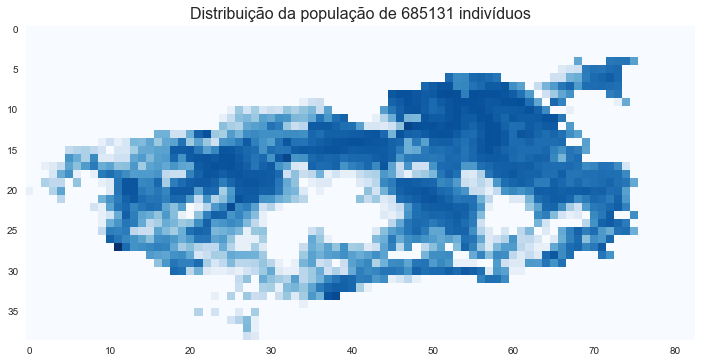

In [26]:
plt.figure(figsize=(12,6))
plt.imshow(np.log(1 + pop_por_bloco), cmap='Blues', interpolation='nearest')
plt.grid(False)
plt.title(f'Distribuição da população de {num_pop} indivíduos', fontsize=16)
plt.show()

### Distribuindo e alocando os indivíduos e as suas residências

In [27]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_bloco, censo_residencial)

CPU times: user 53 s, sys: 3.33 s, total: 56.3 s
Wall time: 57.2 s


In [28]:
len(pos_residencias)
print(f'Média de residentes por residência: {num_pop/len(pos_residencias)}')

Média de residentes por residência: 2.0889286607191857


In [29]:
num_tam_res = len(censo_residencial)
distrib_tam_por_res = np.array([len(res_individuos[k]) for k in range(len(res_individuos))])
distrib_res = np.array([len(distrib_tam_por_res[distrib_tam_por_res == j]) for j in range(1,num_tam_res+1)])
print(f'Número de residências por tamanho: {distrib_res}')

Número de residências por tamanho: [144829  89319  45802  29091  10908   4507   1896   1630]


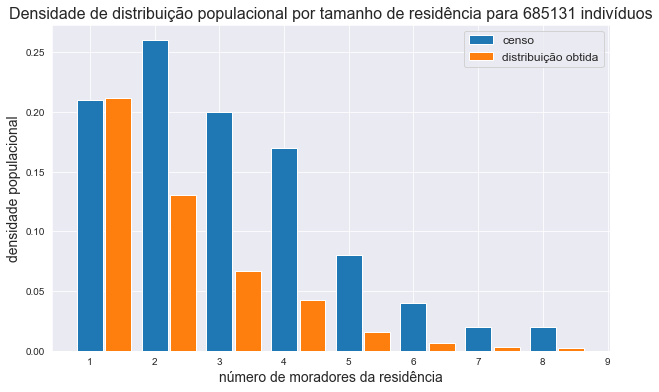

In [30]:
plt.figure(figsize=(10,6))
bar_width = 0.4
r1 = [j for j in range(1,num_tam_res+1)]
r2 = [j + 1.1*bar_width for j in range(1,num_tam_res+1)]
plt.bar(r1, censo_residencial, width=bar_width, label='censo')
plt.bar(r2, distrib_res/num_pop, width=bar_width, label=f'distribuição obtida')
plt.xlabel('número de moradores da residência', fontsize=14)
plt.ylabel('densidade populacional', fontsize=14)
plt.legend(fontsize=12)
plt.title(f'Densidade de distribuição populacional por tamanho de residência para {num_pop} indivíduos',
          fontsize=16)
plt.show()  

### Comparativo do tempo de processamento

O tempo de processamento gasto usando diferentes múltiplos é da seguinte ordem:

| População | Fator | Tempo |
| --- | --- | --- |
| 297 | 1:10000 | ~ 200ms |
| 6 mil | 1:1000 | ~ 260ms |
| 68 mil | 1:100 | ~ 900ms |
| 685 mil | 1:10 | ~ 1 min |
| 6,8 milhões | 1:1 | dia(s) ? |

No último caso, deixei rodando por 10h, até o processo ser interrompido antes de ser concluído.

### Gerando o grafo da rede residencial

In [47]:
%%time
attrib_pos_individuos = {j: pos_individuos[j] for j in range(len(pos_individuos))}

G_r = nx.random_geometric_graph(num_pop, 0, pos=attrib_pos_individuos)

for individuos in res_individuos:
    if len(individuos) > 1:
        G_r.add_edges_from([(i,j) for i in individuos for j in individuos if i < j])

CPU times: user 6.77 s, sys: 549 ms, total: 7.32 s
Wall time: 7.51 s


### Visualização da rede

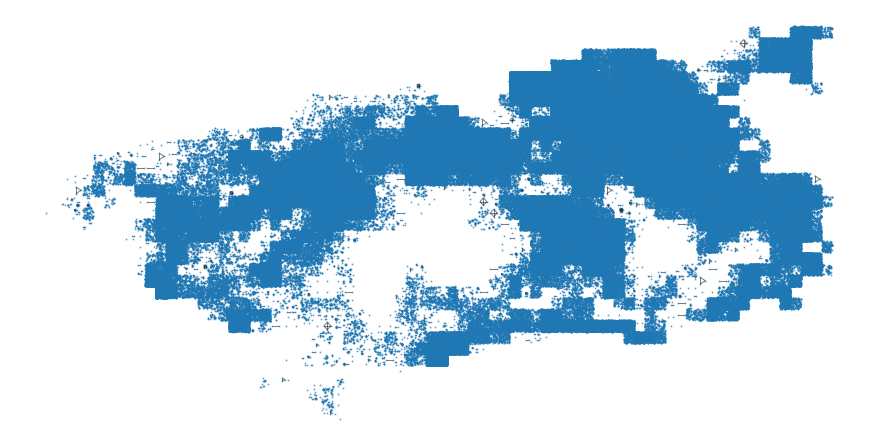

CPU times: user 16.3 s, sys: 493 ms, total: 16.8 s
Wall time: 17.2 s


In [34]:
%%time
plt.figure(figsize=(12,6))
nx.draw(G_r, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
plt.show()

<!--NAVIGATOR-->

---
[<- O cenário de múltiplos do Pop350: parâmetros](19.00-Construindo_Cenarios_e_Pop_Multi_350_parametros.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) | [Modelo individual: incluindo a fase de exposição ->](21.00-Modelo_individual_infeccao_e_recuperacao.ipynb)